# Map VAV Locations

##Background

The goal of the Smart Buildings Control project is to use Reinforcment Learning to control the HVAC systems of real Google Buildings. An important part of this process is to be able to easily oboard new buildings to our pipeline. This notebook provides an easy to use tool to label the locations of VAVs in a real building.

## Why do we need this?
The locations of VAVs in a building is very important. Each VAV gives us a reading, but without knowing where these VAVs are located, they quickly become variables in a black box.

To truly understand how our agents are performing, it is important that we have some tools to open this black box. A key such tool is visualization. If we can visualize what is going in a real building, we can contextualize how our agent is doing, and see how VAVs react based on their location relative to neighboring VAVs.

Below is an example of what a visualization of a real building might look like, with different colors representing the different temperatures being read at each VAV:

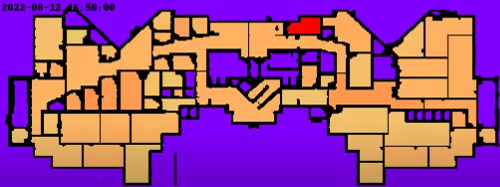

In order to render this, we need to know where each VAV is located.

##The Data
The information we are given about the VAV locations in the building will look something like this:
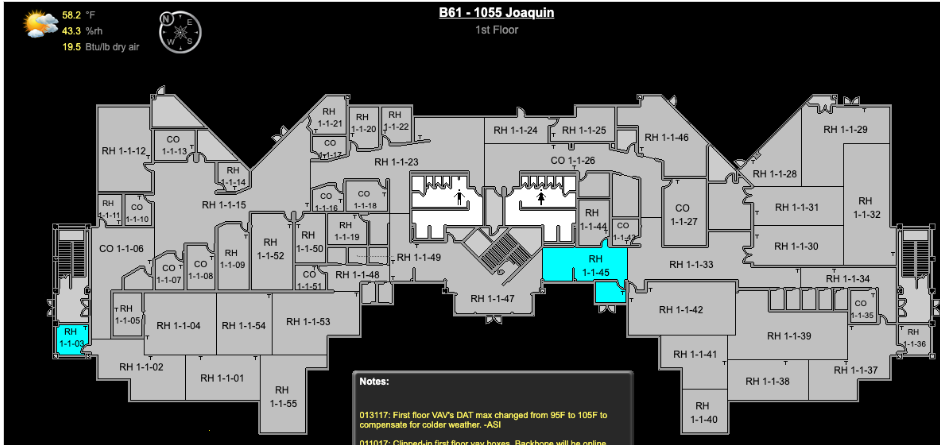

If we clean up the image a bit we can get a cleaner image like:

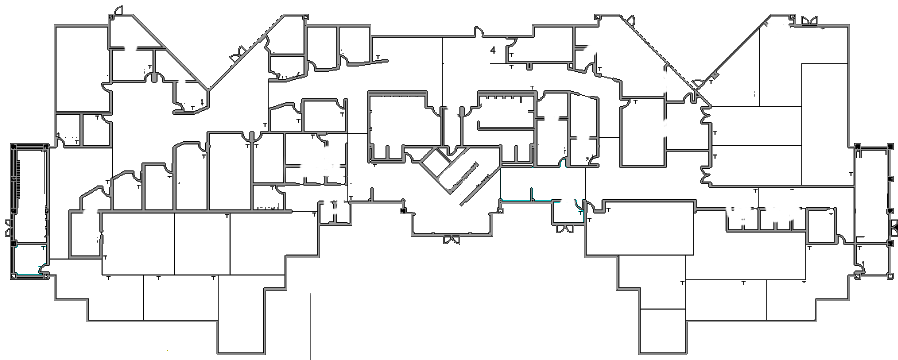

The goal of this notebook is to ingest this cleaned image, and provide an easy UI for labeling which VAV (as found in the first image), goes with which connected component (of the second image).

In [ ]:
#@title Load and Display Floorplan Data

import json
import numpy as np
from IPython import display
import os

floor_plan_path = os.path.join(os.dirname(__file__), "..", "..", "configs", "resources", "sb1" "double_resolution_zone_1_2.npy") #@param {type:"string"}

with open(floor_plan_path, "rb") as fp:
  zone = np.load(fp)
zone[zone==2] = 0

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(np.logical_not(zone), cmap=cm.gray)

In [ ]:
#@title Get Connected Components via Depth First Search


marked = {}
list_of_zones = []
for i in range(zone.shape[0]):
  for j in range(zone.shape[1]):
    if (i,j) in marked:
      continue
    if zone[i][j] == 1:
      continue

    queue = [(i,j)]
    list_of_zone = []
    while queue:
      coords = queue.pop()
      if coords in marked:
        continue

      if coords[0] < 0 or coords[1] < 0 or coords[0] >= zone.shape[0] or coords[1] >= zone.shape[1]:
        continue
      if zone[coords[0]][coords[1]] == 1:
        continue
      queue.append((coords[0],coords[1]+1))
      queue.append((coords[0]+1,coords[1]))
      queue.append((coords[0],coords[1]-1))
      queue.append((coords[0]-1,coords[1]))
      marked[coords] = True
      list_of_zone.append(coords)
    list_of_zones.append(list_of_zone)




In [ ]:
#@title Iterate over each component and ask for its VAV ID

plt.figure(figsize=(10,10), dpi=100)
name_map = {}
for zone_number in range(len(list_of_zones)):
  edited = zone.copy()
  for i in list_of_zones[zone_number]:
    edited[i[0]][i[1]] = 1
  plt.imshow(np.logical_not(edited), cmap=cm.gray)
  display.display(plt.gcf())
  zone_name = input()
  name_map[zone_name] = zone_number
  display.clear_output(wait=True)
name_to_cv_list = {}
for k,v in name_map.items():
  name_to_cv_list[k] = list_of_zones[v]

In [ ]:
#@title Save and Download Files


with open('list_of_zones.json', 'w') as convert_file:
     convert_file.write(json.dumps(list_of_zones))


with open('name_map.json', 'w') as convert_file:
     convert_file.write(json.dumps(name_map))


In [ ]:
with open('name_to_cv_list.json', 'w') as convert_file:
     convert_file.write(json.dumps(name_to_cv_list))
